In [1]:
library(dplyr)   
library(caret)
library(tidyverse)
library(recipes)
library(pROC)
library(caTools)
library(UBL)


options(repr.plot.width = 20, repr.plot.height =10, repr.plot.res = 100)


load(file = "C:/Users/abonini/Desktop/Analysis/Sources/LIVERTRANSPLANT/Modello/df.Rdata")

Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'caret' was built under R version 3.6.3"
Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 3.6.2"
Loading required package: ggplot2

Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.1.0     v purrr   0.3.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'tibble' was built under R version 3.6.2"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'readr' was built under R version 3.6.3"
Warning message:
"pack

In [2]:
dim(df)

[1] 1068   78

# Feature selection

Warning message:
"package 'Boruta' was built under R version 3.6.3"
 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

After 13 iterations, +1.3 mins: 

 confirmed 10 attributes: centreCode, degenzaPreTra, intermedLactates, IntraoperativTransfected, new_admWard and 5 more;

 rejected 35 attributes: age, anastomTechnic, BleedingEsophagGastric, coldIschemia, colestatiche and 30 more;

 still have 32 attributes left.


 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

After 18 iterations, +1.7 mi

 [1] "centreCode"               "degenzaPreTra"           
 [3] "thrombosisDegreeWithNone" "albumInfusOver7Days"     
 [5] "ratioPaO2FiO2"            "platCountTranspl"        
 [7] "albumina"                 "surgeryDuration"         
 [9] "IntraoperativTransfected" "plasmaFresco"            
[11] "plasmaPools"              "doseFibrinogen"          
[13] "CristalloidiComp"         "Albumina50Comp"          
[15] "noradrenalineEndSurger"   "intermedLactates"        
[17] "syndromeReperfus"         "venousBypass"            
[19] "abdomOpenEndSurg"         "scoreCHILD"              
[21] "organDonorType"           "organDonorSampleTechnic" 
[23] "realMELD"                 "new_admWard"             
[25] "EPScum"                   "comorbidities_renali"    


ERROR: Error in match.fun(FUN): l'argomento "FUN"  non è specificato e non ha un valore predefinito


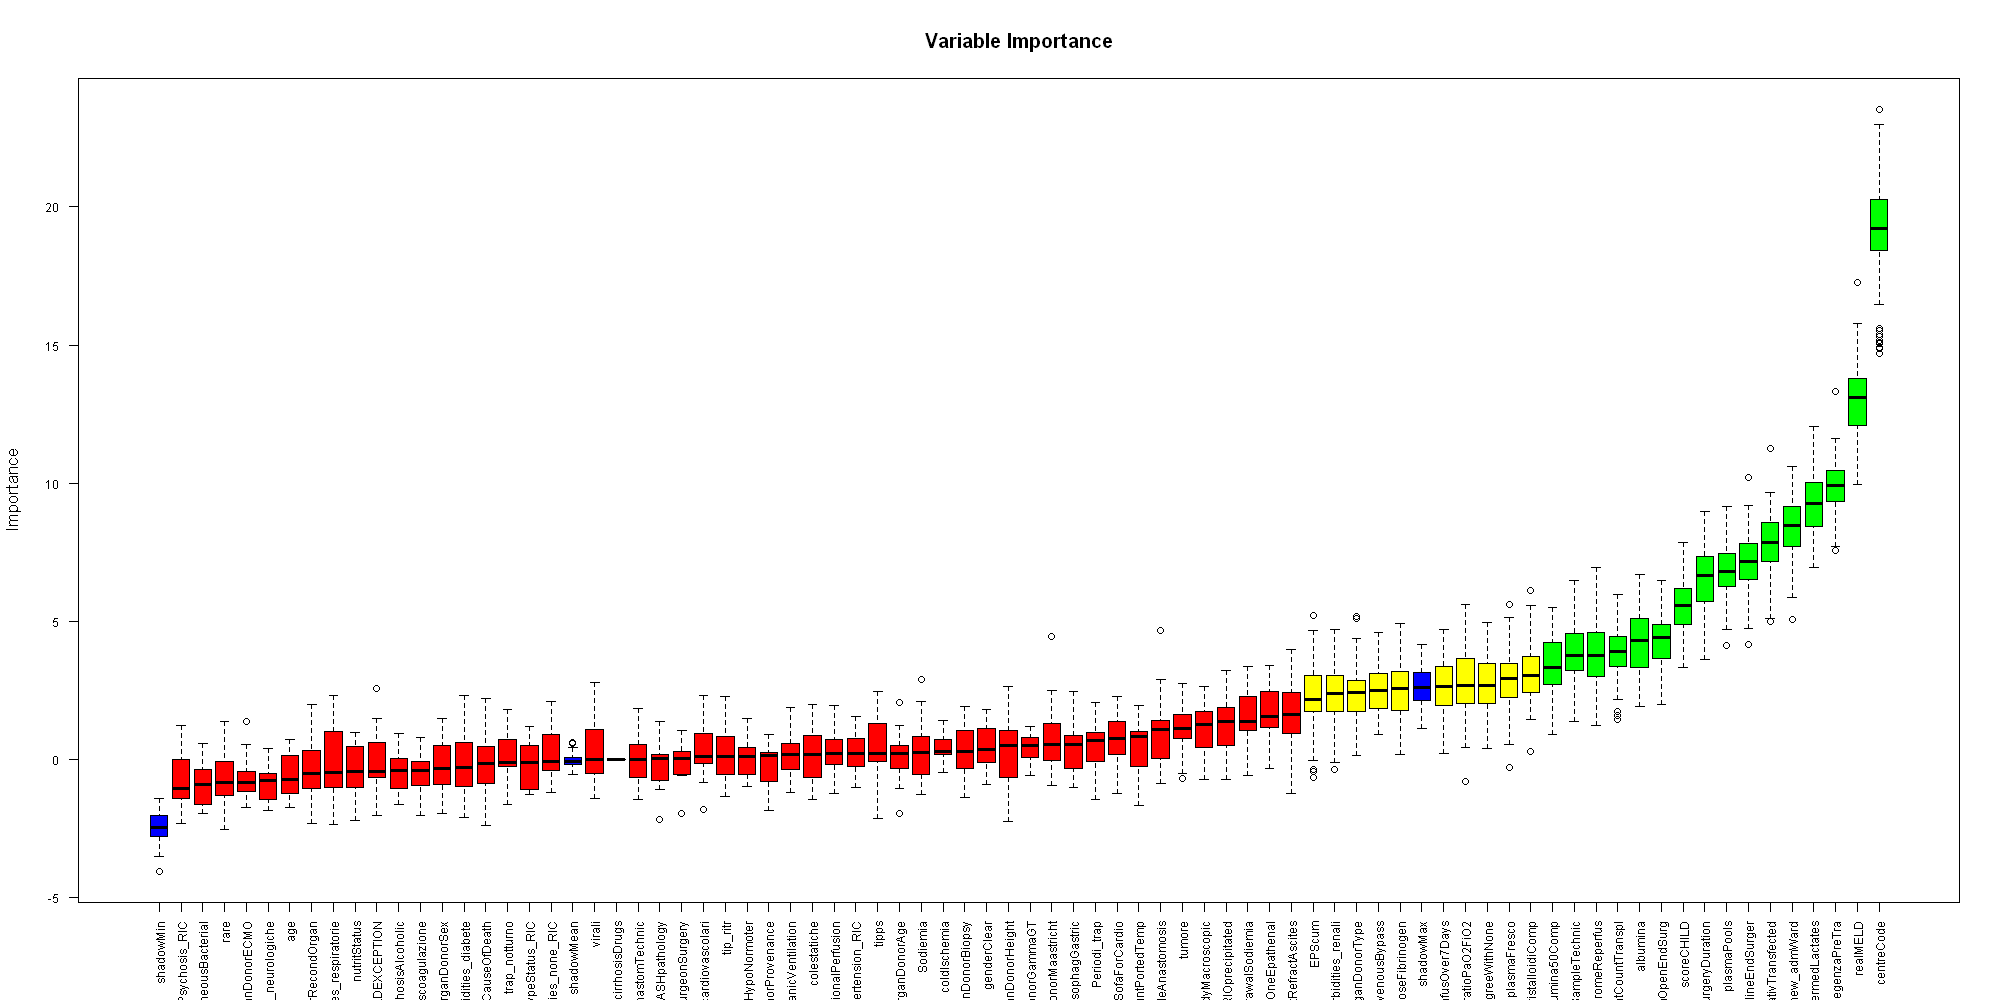

In [2]:
library(Boruta)
# Decide if a variable is important or not using Boruta
boruta_output <- Boruta(deg_cat ~ ., data=df, doTrace=2)  # perform Boruta search


boruta_signif <- names(boruta_output$finalDecision[boruta_output$finalDecision %in% c("Confirmed", "Tentative")])  # collect Confirmed and Tentative variables
print(boruta_signif)  # significant variables


plot(boruta_output, cex.axis=.7, las=2, xlab="", main="Variable Importance")  # plot variable importance


df_boruta <- df[,boruta_signif]

df_boruta <- apply(select_if(df,is.matrix),as.numeric)


In [4]:
df_boruta$deg_cat <- df$deg_cat

## Data partition

In [5]:
#make this example reproducible
set.seed(1)

#use 70% of dataset as training set and 30% as test set
sample <- sample.split(df$deg_cat, SplitRatio = 0.7)
train  <- subset(df, sample == TRUE)
test   <- subset(df, sample == FALSE)



TestClasses <- test$deg_cat
TestData <- subset(test,select= -deg_cat)



In [6]:
train <- SmoteClassif(deg_cat ~ ., train, k = 27, dist = "HEOM")

#view distribution of response variable in new dataset
table(train$deg_cat)

TrainClasses <- train$deg_cat
TrainData <- subset(train,select= -deg_cat)


Accettabile  Complicato      Ottimo 
        249         249         249 

In [7]:
#make this example reproducible
set.seed(1)

#use 70% of dataset as training set and 30% as test set
sample <- sample.split(df_boruta$deg_cat, SplitRatio = 0.7)
trainB  <- subset(df_boruta, sample == TRUE)
testB   <- subset(df_boruta, sample == FALSE)



TestClassesB <- testB$deg_cat
TestDataB <- subset(testB,select= -deg_cat)


In [8]:
trainB <- SmoteClassif(deg_cat ~ ., trainB, k = 27, dist = "HEOM")

#view distribution of response variable in new dataset
table(trainB$deg_cat)

TrainClassesB <- trainB$deg_cat
TrainDataB <- subset(trainB,select= -deg_cat)


Accettabile  Complicato      Ottimo 
        249         249         249 

## Models

In [9]:
ctrl <- trainControl(method = "repeatedcv", 
                 number = 10, 
                 savePredictions = "final",classProbs=TRUE,verboseIter=TRUE, search= "random") 

#summaryFunction = multiClassSummary (to keep all metrics)

In [10]:
model_knn <- train(x=TrainData, y=TrainClasses, 
               method = "kknn",
               trControl = ctrl) 

+ Fold01.Rep1: kmax=130, distance=2.769, kernel=cos 
- Fold01.Rep1: kmax=130, distance=2.769, kernel=cos 
+ Fold01.Rep1: kmax=166, distance=1.471, kernel=gaussian 
- Fold01.Rep1: kmax=166, distance=1.471, kernel=gaussian 
+ Fold01.Rep1: kmax= 16, distance=1.477, kernel=inv 
- Fold01.Rep1: kmax= 16, distance=1.477, kernel=inv 
+ Fold02.Rep1: kmax=130, distance=2.769, kernel=cos 
- Fold02.Rep1: kmax=130, distance=2.769, kernel=cos 
+ Fold02.Rep1: kmax=166, distance=1.471, kernel=gaussian 
- Fold02.Rep1: kmax=166, distance=1.471, kernel=gaussian 
+ Fold02.Rep1: kmax= 16, distance=1.477, kernel=inv 
- Fold02.Rep1: kmax= 16, distance=1.477, kernel=inv 
+ Fold03.Rep1: kmax=130, distance=2.769, kernel=cos 
- Fold03.Rep1: kmax=130, distance=2.769, kernel=cos 
+ Fold03.Rep1: kmax=166, distance=1.471, kernel=gaussian 
- Fold03.Rep1: kmax=166, distance=1.471, kernel=gaussian 
+ Fold03.Rep1: kmax= 16, distance=1.477, kernel=inv 
- Fold03.Rep1: kmax= 16, distance=1.477, kernel=inv 
+ Fold04.Rep1: k

In [11]:
model_knnB <- train(x=TrainDataB, y=TrainClassesB, 
               method = "kknn",
               trControl = ctrl) 

+ Fold01.Rep1: kmax=235, distance=0.88473, kernel=epanechnikov 
- Fold01.Rep1: kmax=235, distance=0.88473, kernel=epanechnikov 
+ Fold01.Rep1: kmax= 13, distance=0.01334, kernel=inv 
- Fold01.Rep1: kmax= 13, distance=0.01334, kernel=inv 
+ Fold01.Rep1: kmax= 82, distance=1.49639, kernel=gaussian 
- Fold01.Rep1: kmax= 82, distance=1.49639, kernel=gaussian 
+ Fold02.Rep1: kmax=235, distance=0.88473, kernel=epanechnikov 
- Fold02.Rep1: kmax=235, distance=0.88473, kernel=epanechnikov 
+ Fold02.Rep1: kmax= 13, distance=0.01334, kernel=inv 
- Fold02.Rep1: kmax= 13, distance=0.01334, kernel=inv 
+ Fold02.Rep1: kmax= 82, distance=1.49639, kernel=gaussian 
- Fold02.Rep1: kmax= 82, distance=1.49639, kernel=gaussian 
+ Fold03.Rep1: kmax=235, distance=0.88473, kernel=epanechnikov 
- Fold03.Rep1: kmax=235, distance=0.88473, kernel=epanechnikov 
+ Fold03.Rep1: kmax= 13, distance=0.01334, kernel=inv 
- Fold03.Rep1: kmax= 13, distance=0.01334, kernel=inv 
+ Fold03.Rep1: kmax= 82, distance=1.49639, ker

## Results

k-Nearest Neighbors 

747 samples
 77 predictor
  3 classes: 'Accettabile', 'Complicato', 'Ottimo' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 673, 672, 672, 672, 673, 672, ... 
Resampling results across tuning parameters:

  kmax  distance  kernel    Accuracy   Kappa    
   16   1.476855  inv       0.5956757  0.3935399
  130   2.769153  cos       0.5795315  0.3694892
  166   1.470758  gaussian  0.5956757  0.3935399

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were kmax = 166, distance = 1.470758
 and kernel = gaussian.


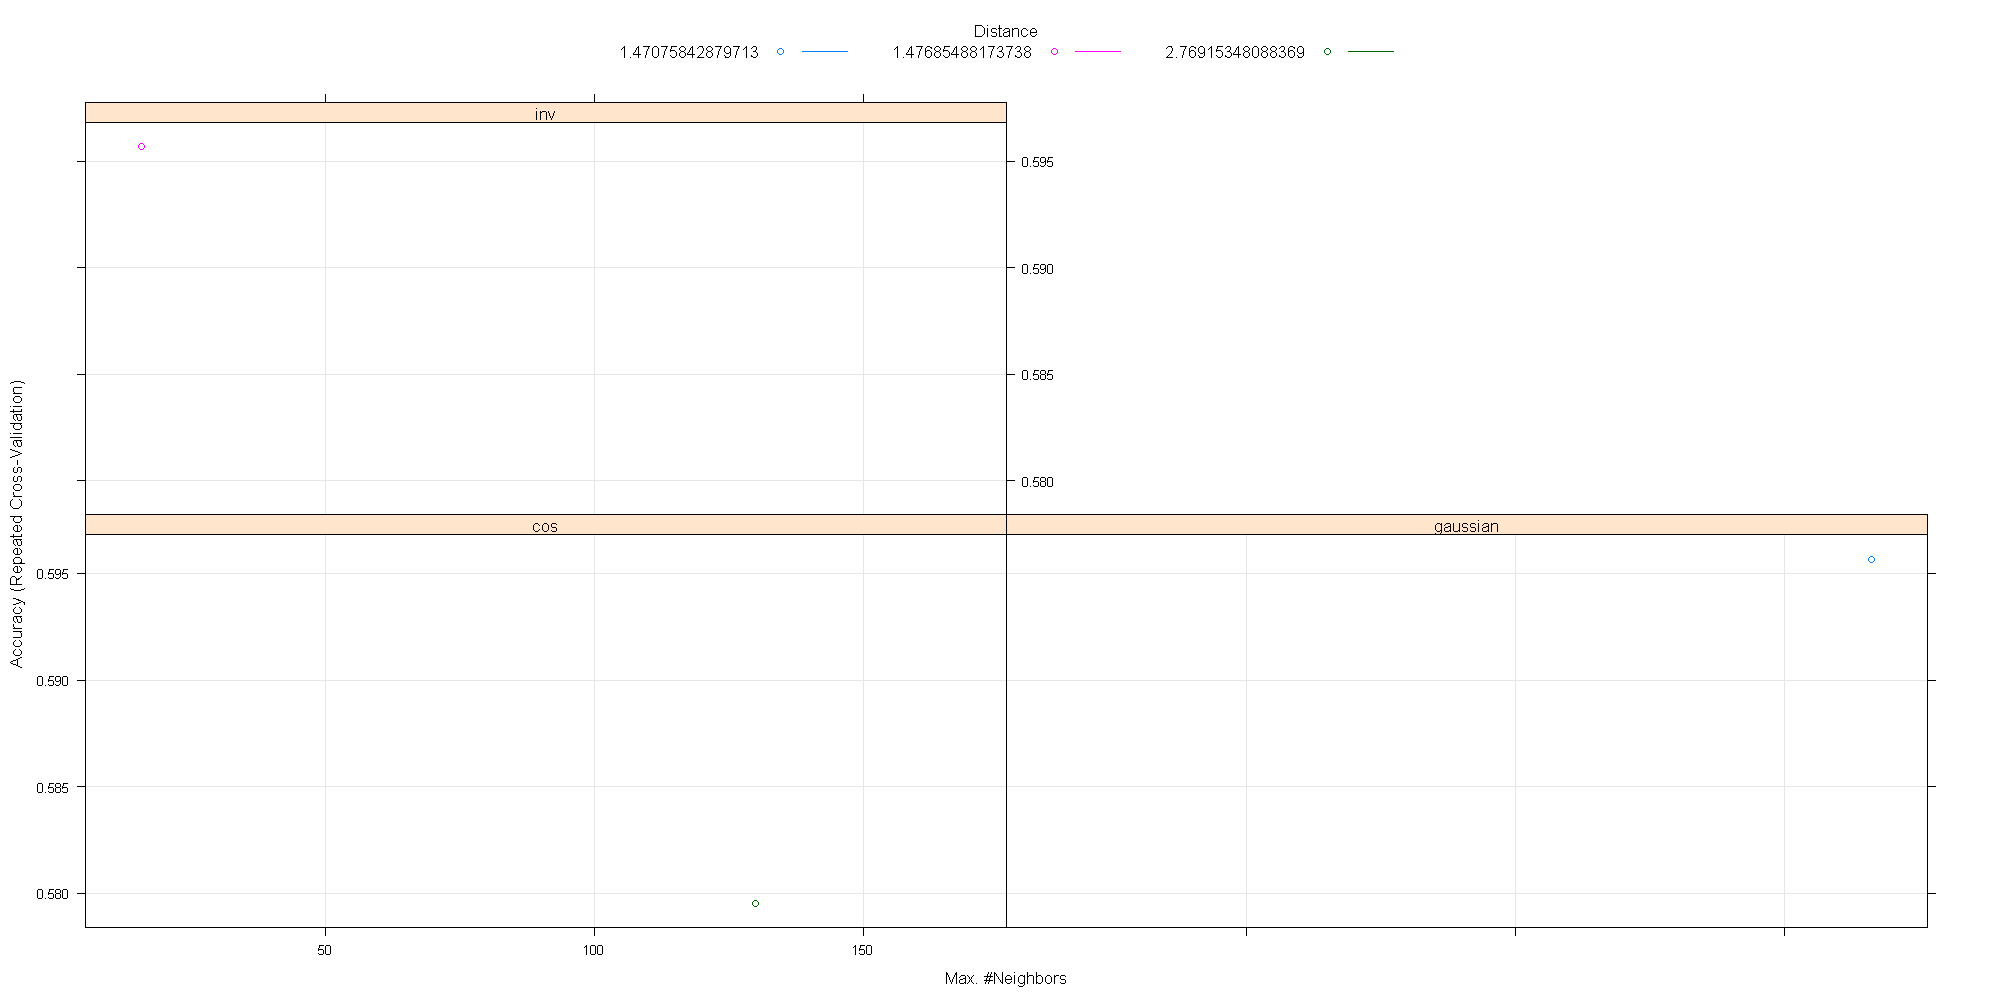

In [12]:
print(model_knn)
plot(model_knn)

k-Nearest Neighbors 

747 samples
 26 predictor
  3 classes: 'Accettabile', 'Complicato', 'Ottimo' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 672, 672, 672, 672, 673, 673, ... 
Resampling results across tuning parameters:

  kmax  distance    kernel        Accuracy   Kappa    
   13   0.01334422  inv           0.5463243  0.3194806
   82   1.49639340  gaussian      0.5916396  0.3871923
  235   0.88473335  epanechnikov  0.5890450  0.3835355

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were kmax = 82, distance = 1.496393
 and kernel = gaussian.


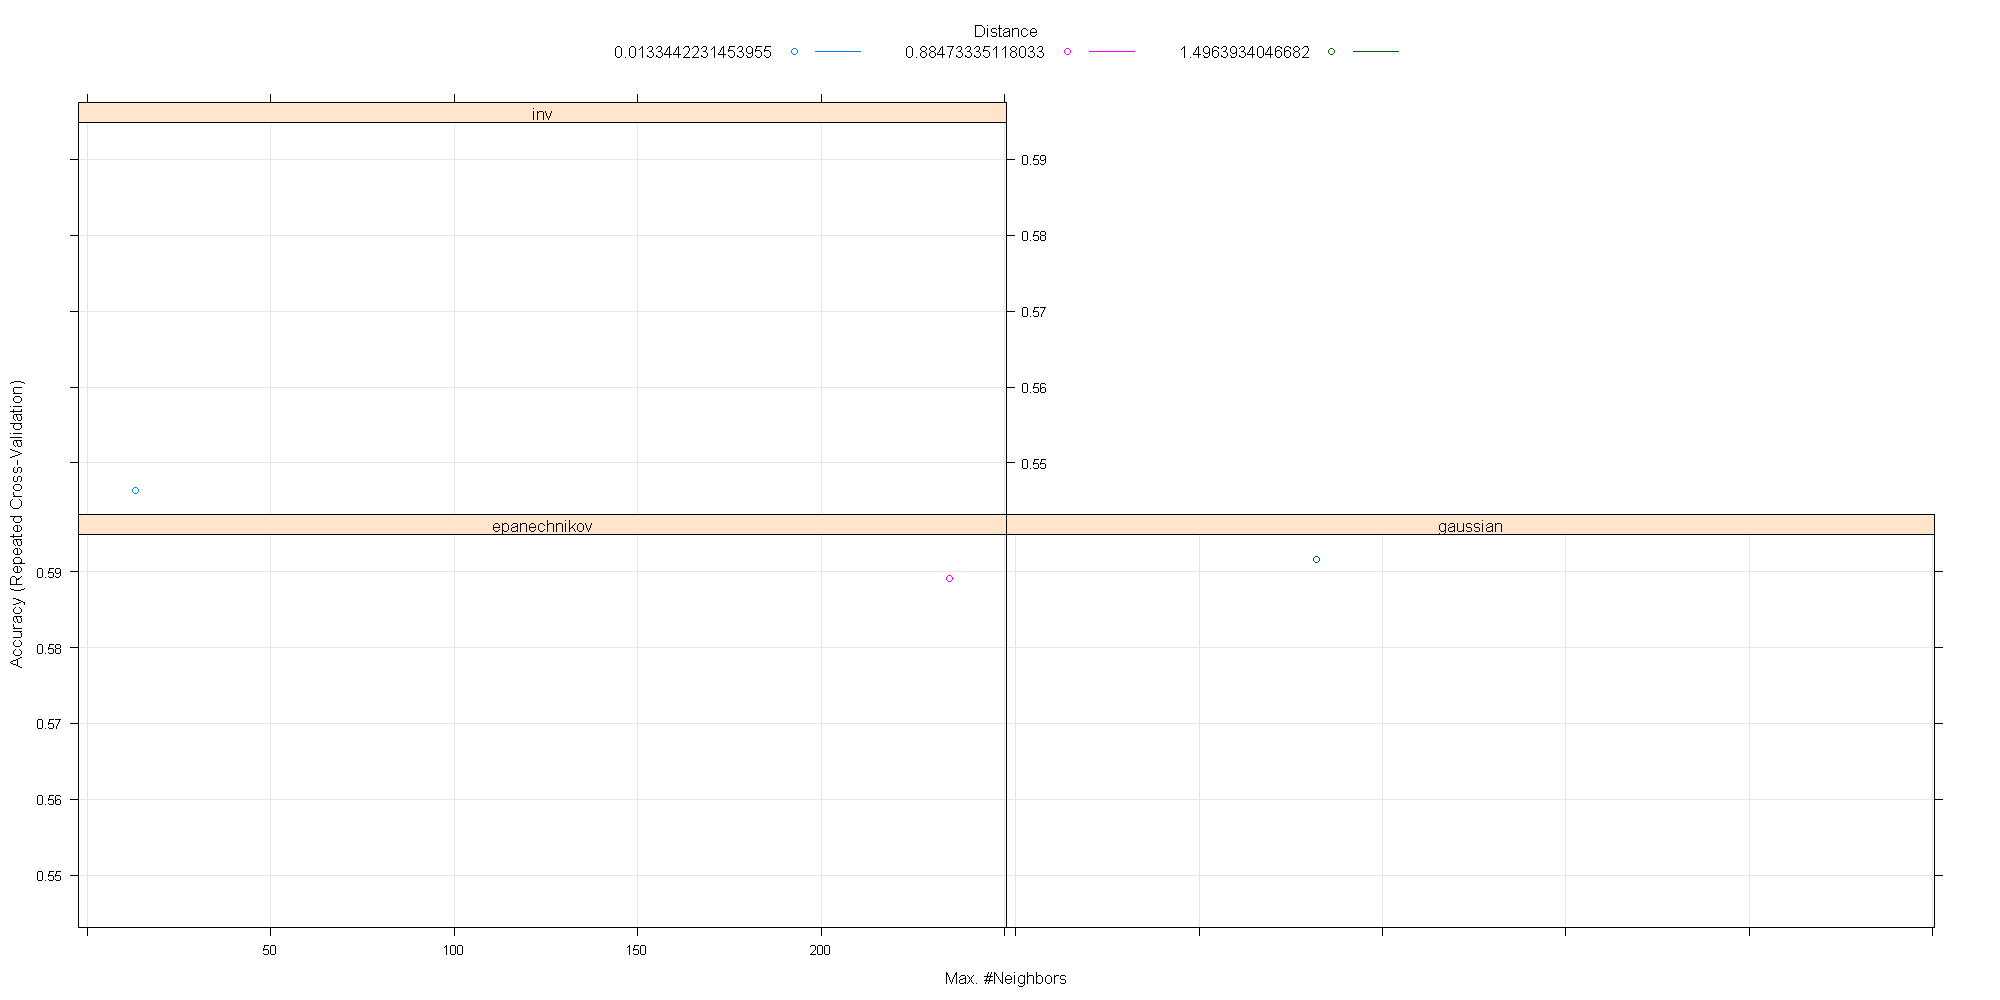

In [13]:
print(model_knnB)
plot(model_knnB)


Call:
summary.resamples(object = results)

Models: knn, knn_boruta 
Number of resamples: 10 

Accuracy 
                Min.  1st Qu.    Median      Mean   3rd Qu.      Max. NA's
knn        0.5405405 0.569009 0.5933333 0.5956757 0.6266667 0.6486486    0
knn_boruta 0.5405405 0.569009 0.5933333 0.5956757 0.6266667 0.6486486    0

Kappa 
                Min.   1st Qu. Median      Mean 3rd Qu.      Max. NA's
knn        0.3136934 0.3524897   0.39 0.3935399    0.44 0.4717188    0
knn_boruta 0.3136934 0.3524897   0.39 0.3935399    0.44 0.4717188    0


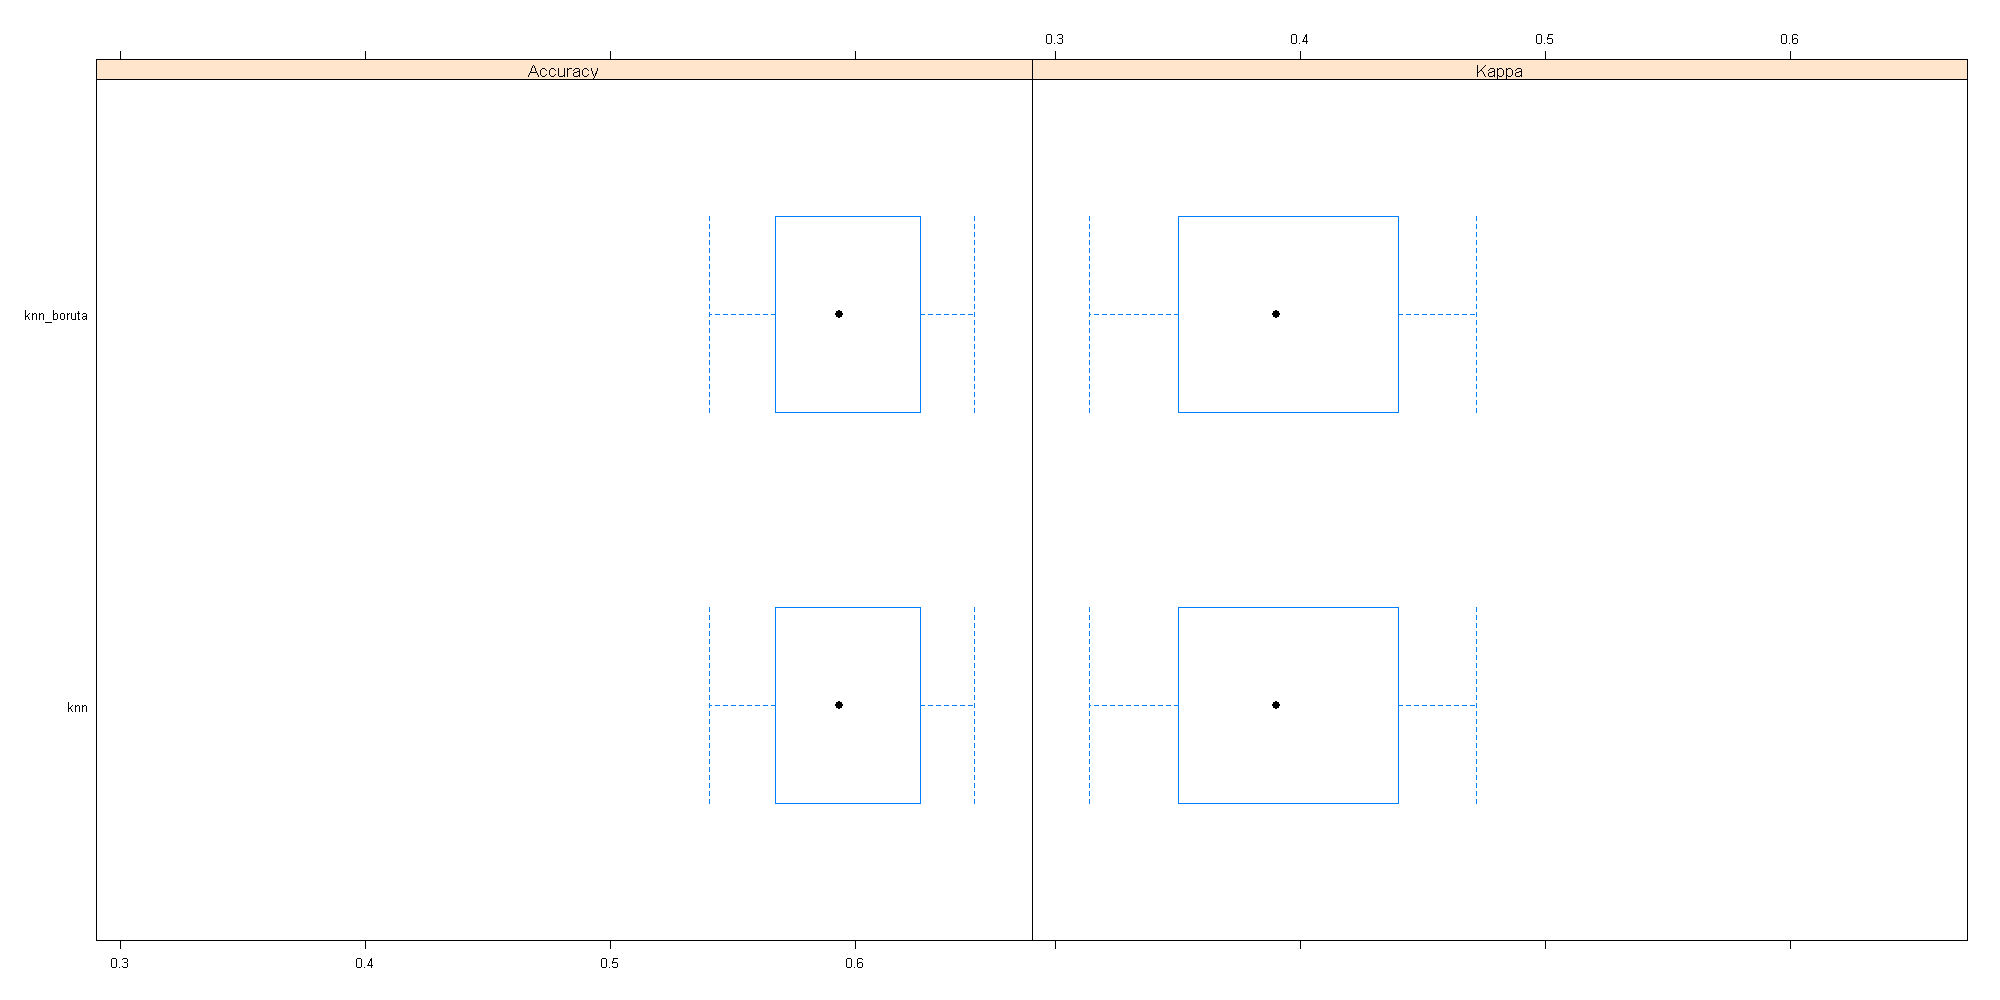

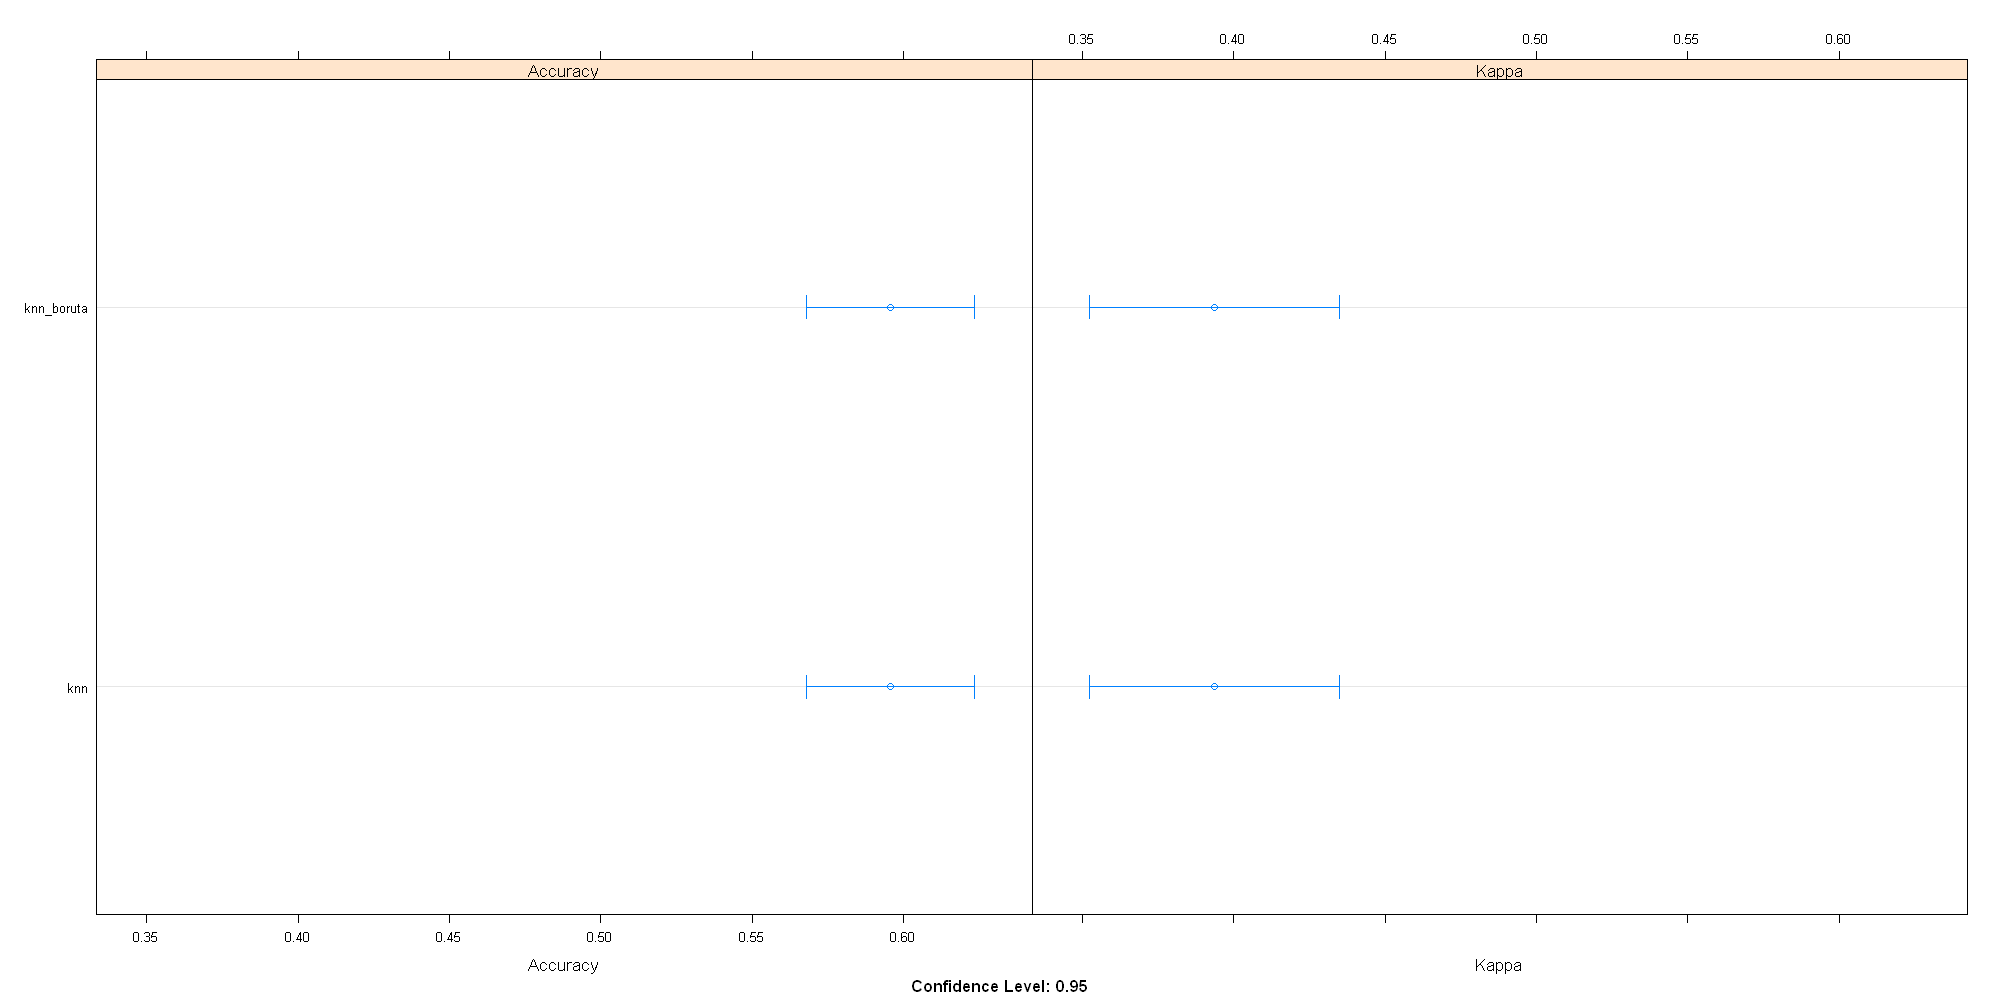

In [14]:
# collect resamples
results <- resamples(list(knn=model_knn,knn_boruta=model_knn))
# summarize the distributions
summary(results)
# boxplots of results
bwplot(results)
# dot plots of results
dotplot(results)

## Prediction

In [15]:
pred_knn <- predict(model_knnB,test)  
pred_knn.prob <- predict(model_knnB,test, type="prob")


result <- confusionMatrix(TestClasses,  pred_knn) 
result
result$byClass

Confusion Matrix and Statistics

             Reference
Prediction    Accettabile Complicato Ottimo
  Accettabile          58         26     72
  Complicato           33         61     28
  Ottimo                3          3     37

Overall Statistics
                                          
               Accuracy : 0.486           
                 95% CI : (0.4301, 0.5421)
    No Information Rate : 0.4268          
    P-Value [Acc > NIR] : 0.01875         
                                          
                  Kappa : 0.2593          
                                          
 Mcnemar's Test P-Value : < 2e-16         

Statistics by Class:

                     Class: Accettabile Class: Complicato Class: Ottimo
Sensitivity                      0.6170            0.6778        0.2701
Specificity                      0.5683            0.7359        0.9674
Pos Pred Value                   0.3718            0.5000        0.8605
Neg Pred Value                   0.7818           

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
Class: Accettabile,0.6170213,0.5682819,0.3717949,0.7818182,0.3717949,0.6170213,0.4640000,0.2928349,0.1806854,0.4859813,0.5926516
Class: Complicato,0.6777778,0.7359307,0.5000000,0.8542714,0.5000000,0.6777778,0.5754717,0.2803738,0.1900312,0.3800623,0.7068543
Class: Ottimo,0.2700730,0.9673913,0.8604651,0.6402878,0.8604651,0.2700730,0.4111111,0.4267913,0.1152648,0.1339564,0.6187321


In [16]:
roc_knn <- multiclass.roc(TestClasses, as.numeric(pred_knn))
roc_knn



Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases




Call:
multiclass.roc.default(response = TestClasses, predictor = as.numeric(pred_knn))

Data: as.numeric(pred_knn) with 3 levels of TestClasses: Accettabile, Complicato, Ottimo.
Multi-class area under the curve: 0.6562

percent,FALSE,FALSE
sensitivities,"1.0000000, 0.9302326, 0.8604651, 0.0000000","1.0000000, 0.9302326, 0.8604651, 0.0000000"
specificities,"0.0000000, 0.3717949, 0.5384615, 1.0000000","0.0000000, 0.2704918, 0.7704918, 1.0000000"
thresholds,"-Inf, 1.5, 2.5, Inf","-Inf, 1.5, 2.5, Inf"
direction,<,<
cases,"3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 2, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3","3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 2, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3"
controls,"3, 2, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 3, 1, 2, 2, 3, 1, 1, 1, 1, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 1, 2, 2, 2, 2, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 2, 3, 2, 1, 3, 1, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 3, 2, 1, 3, 2, 3, 1, 1, 1","3, 1, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 2, 1, 3, 2, 1, 2, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 3, 3, 2, 1, 3, 3, 2, 3, 1, 3, 3, 2, 2, 3, 2, 2, 3, 1, 2, 2, 1, 1, 2, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 1, 2, 3, 2, 3, 1, 3, 2, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1"
fun.sesp,"function (thresholds, controls, cases, direction) , {, ncontrols <- length(controls), ncases <- length(cases), predictor <- c(controls, cases), response <- c(rep(0, length(controls)), rep(1, length(cases))), decr <- direction == ""<"", predictor.order <- order(predictor, decreasing = decr), predictor.sorted <- predictor[predictor.order], response.sorted <- response[predictor.order], tp <- cumsum(response.sorted == 1), fp <- cumsum(response.sorted == 0), se <- tp/ncases, sp <- (ncontrols - fp)/ncontrols, dups.pred <- rev(duplicated(rev(predictor.sorted))), dups.sesp <- duplicated(se) & duplicated(sp), dups <- dups.pred | dups.sesp, if (sum(!dups) != length(thresholds) - 1) {, sessionInfo <- sessionInfo(), save(thresholds, controls, cases, direction, sessionInfo, , file = ""pROC_bug.RData""), stop(sprintf(""pROC: fast algorithm computed an incorrect number of sensitivities and specificities. Diagnostic data saved in pROC_bug.RData. Please report this bug to <%s>."", , utils::packageDescription(""pROC"")$BugReports)), }, if (direction == ""<"") {, se <- rev(c(0, se[!dups])), sp <- rev(c(1, sp[!dups])), }, else {, se <- c(0, se[!dups]), sp <- c(1, sp[!dups]), }, return(list(se = se, sp = sp)), }","function (thresholds, controls, cases, direction) , {, ncontrols <- length(controls), ncases <- length(cases), predictor <- c(controls, cases), response <- c(rep(0, length(controls)), rep(1, length(cases))), decr <- direction == ""<"", predictor.order <- order(predictor, decreasing = decr), predictor.sorted <- predictor[predictor.order], response.sorted <- response[predictor.order], tp <- cumsum(response.sorted == 1), fp <- cumsum(response.sorted == 0), se <- tp/ncases, sp <- (ncontrols - fp)/ncontrols, dups.pred <- rev(duplicated(rev(predictor.sorted))), dups.sesp <- duplicated(se) & duplicated(sp), dups <- dups.pred | dups.sesp, if (sum(!dups) != length(thresholds) - 1) {, sessionInfo <- sessionInfo(), save(thresholds, controls, cases, direction, sessionInfo, , file = ""pROC_bug.RData""), stop(sprintf(""pROC: fast algorithm computed an incorrect number of sensitivities and specificities. Diagnostic data saved in pROC_bug.RData. Please report this bug to <%s>."", , utils::packageDescription(""pROC"")$BugReports)), }, if (direction == ""<"") {, se <- rev(c(0, se[!dups])), sp <- rev(c(1, sp[!dups])), }, else {, se <- c(0, se[!dups]), sp <- c(1, sp[!dups]), }, return(list(se = se, sp = sp)), }"
call,"roc.default(response = response, predictor = predictor, levels = X, , percent = percent, direction = ..1, auc = FALSE, ci = FALSE)","roc.default(respon

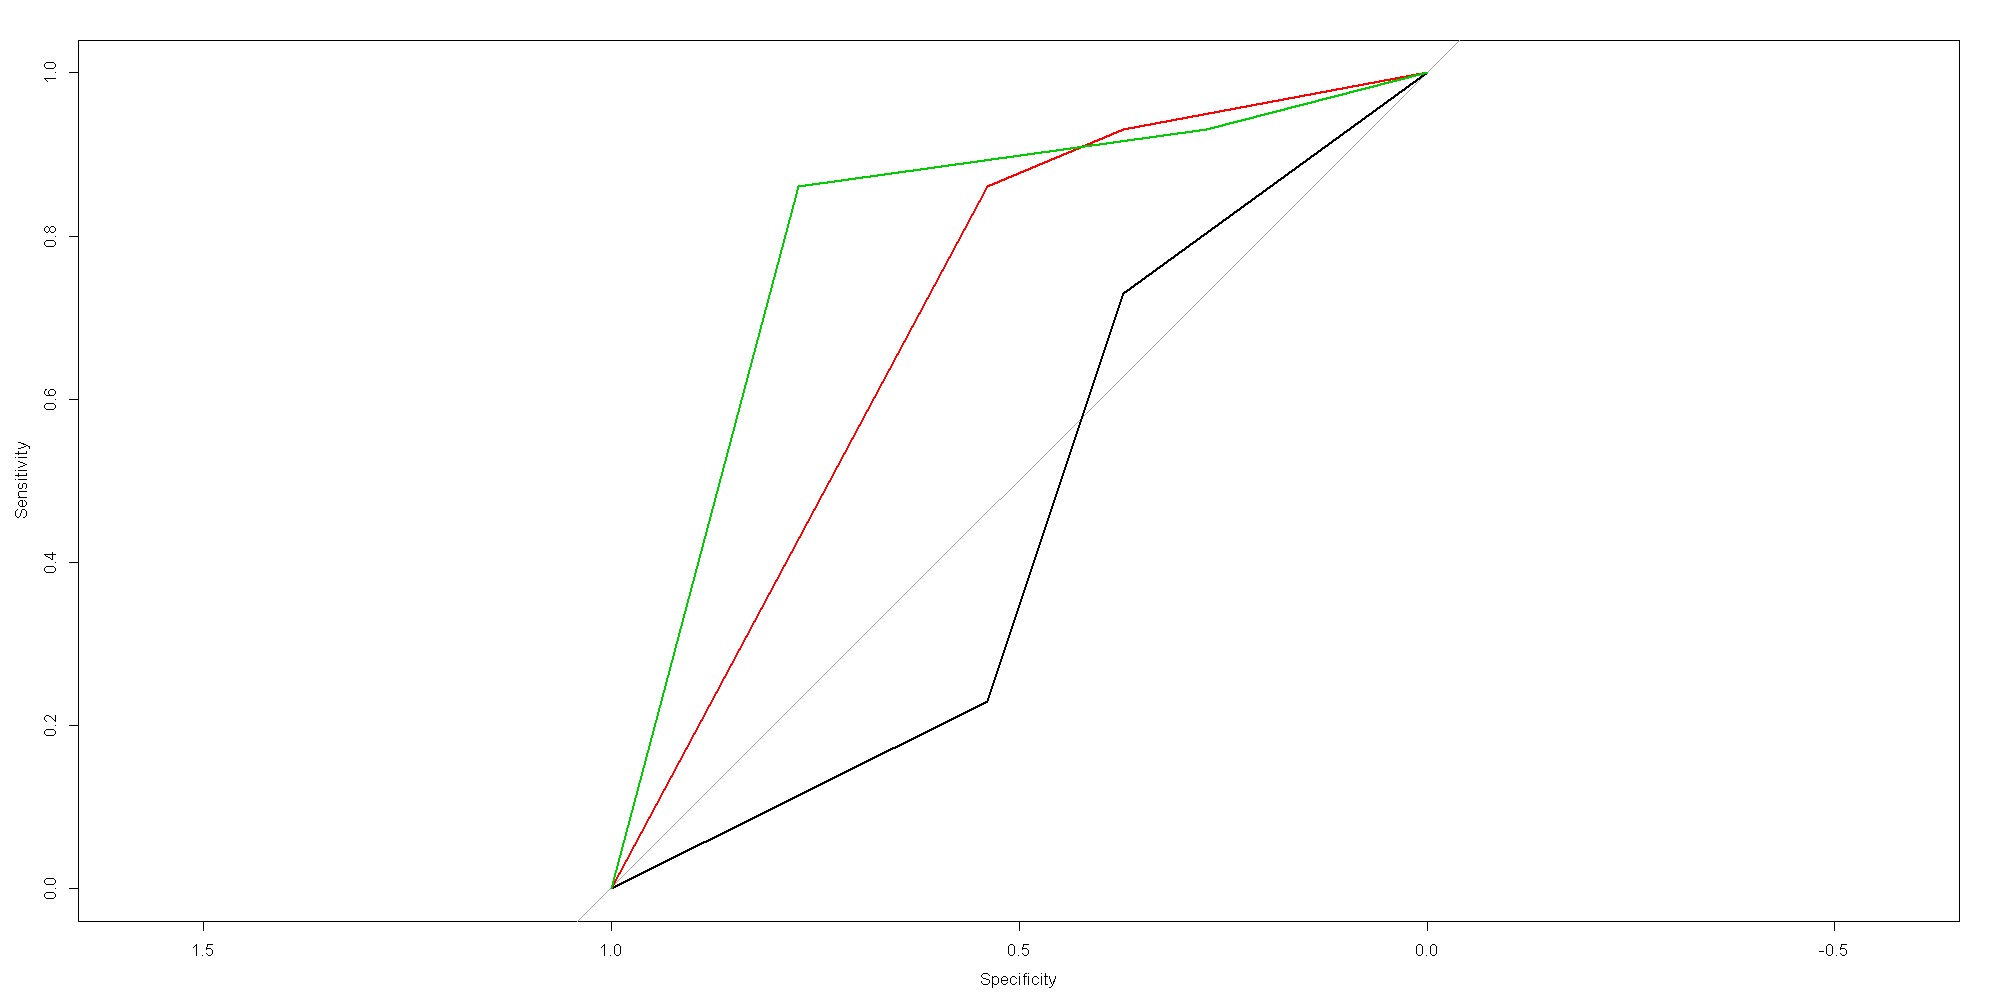

In [19]:
rs <- roc_knn[['rocs']]
plot.roc(rs[[1]])
sapply(2:length(rs),function(i) lines.roc(rs[[i]],col=i))

In [17]:
pred_knn.prob

Accettabile,Complicato,Ottimo
0.24798442,0.06719127,0.68482430
0.32963594,0.60174809,0.06861597
0.38490938,0.21105862,0.40403200
0.56550429,0.23120189,0.20329381
0.49774079,0.13748208,0.36477714
0.30942913,0.43336641,0.25720446
0.28376606,0.00000000,0.71623394
0.19290661,0.03774112,0.76935228
0.16890897,0.00000000,0.83109103
0.15834074,0.84165926,0.00000000
